In [1]:
%load_ext autoreload
%autoreload 2

# IMPORTS

In [2]:
import sys
import pandas as pd
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.utils.timer import Timer
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.models.ncf.dataset import Dataset as NCFDataset
from recommenders.datasets import movielens
from recommenders.utils.notebook_utils import is_jupyter
from recommenders.datasets.python_splitters import python_chrono_split
from recommenders.evaluation.python_evaluation import (rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k, 
                                                     recall_at_k, get_top_k_items)

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))

System version: 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
Pandas version: 1.4.2
Tensorflow version: 2.9.3


# HYPERPARAMETERS

In [3]:
# top k items to recommend
TOP_K = 10

# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '100k'

# Model parameters
EPOCHS = 100
BATCH_SIZE = 256

SEED = 42

# DATA PREPARATION

In [4]:
df = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    header=["userID", "itemID", "rating", "timestamp"]
)

INFO:recommenders.datasets.download_utils:Downloading https://files.grouplens.org/datasets/movielens/ml-100k.zip
100%|██████████████████████████████████████████████████████████████████████████████| 4.81k/4.81k [00:09<00:00, 506KB/s]


In [5]:
train, test = python_chrono_split(df, 0.75)

In [6]:
test = test[test["userID"].isin(train["userID"].unique())]
test = test[test["itemID"].isin(train["itemID"].unique())]

In [7]:
train_file = "./train.csv"
test_file = "./test.csv"
train.to_csv(train_file, index=False)
test.to_csv(test_file, index=False)

In [8]:
data = NCFDataset(train_file=train_file, test_file=test_file, seed=SEED)

INFO:recommenders.models.ncf.dataset:Indexing ./train.csv ...
INFO:recommenders.models.ncf.dataset:Indexing ./test.csv ...
INFO:recommenders.models.ncf.dataset:Indexing ./test_full.csv ...


# BUILD MODEL

In [9]:
model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=16,
    layer_sizes=[16,8,4],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)

C:\Users\Ammar Haziq\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


# TRAINING

In [10]:
with Timer() as train_time:
    model.fit(data)

print("Took {} seconds for training.".format(train_time))

INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [3.19s]: train_loss = 0.218392 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [3.17s]: train_loss = 0.194174 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [3.26s]: train_loss = 0.185497 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [3.20s]: train_loss = 0.179937 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [3.18s]: train_loss = 0.175082 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [3.14s]: train_loss = 0.171260 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [3.10s]: train_loss = 0.168864 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [3.13s]: train_loss = 0.167346 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [3.09s]: train_loss = 0.166061 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [3.11s]: train_loss = 0.164153 


Took 317.6198 seconds for training.


# INFERENCE

In [11]:
with Timer() as test_time:
    users, items, preds = [], [], []
    item = list(train.itemID.unique())
    for user in train.userID.unique():
        user = [user] * len(item) 
        users.extend(user)
        items.extend(item)
        preds.extend(list(model.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

    merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

print("Took {} seconds for prediction.".format(test_time))

Took 2.6772 seconds for prediction.


In [12]:
all_predictions

,userID,itemID,timestamp,prediction
74992,1,286,NaN,6.301048e-01
74993,1,258,NaN,6.650531e-01
74994,1,305,NaN,9.343430e-02
74995,1,307,NaN,6.941572e-02
74996,1,288,NaN,6.760817e-01
...,...,...,...,...
1505966,943,1592,NaN,3.747650e-11
1505967,943,1676,NaN,6.867967e-08
1505968,943,907,NaN,1.830687e-10
1505969,943,1681,NaN,2.351495e-11


In [13]:
eval_map = map_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.045272
NDCG:	0.193614
Precision@K:	0.175822
Recall@K:	0.099722


In [14]:
if is_jupyter():
    # Record results with papermill for tests
    import papermill as pm
    import scrapbook as sb
    sb.glue("map", eval_map)
    sb.glue("ndcg", eval_ndcg)
    sb.glue("precision", eval_precision)
    sb.glue("recall", eval_recall)
    sb.glue("train_time", train_time.interval)
    sb.glue("test_time", test_time.interval)

In [15]:
eval_precision

0.1758218451749735

# TRAINING GRAPH

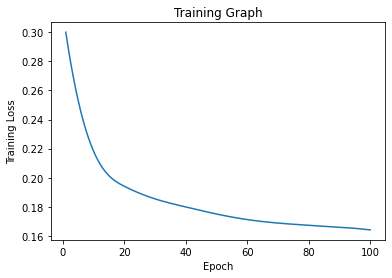

In [17]:
import numpy as np
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
 
# Dataset
x = np.array([1,10,20,30,40,50,60,70,80,90,100])
y = np.array([0.3, 0.218392 , 0.194174 , 0.185497 , 0.179937 , 0.175082 , 0.171260 , 0.168864 , 0.167346 , 0.166061 , 0.164153])
 
X_Y_Spline = make_interp_spline(x, y)
 
# Returns evenly spaced numbers
# over a specified interval.
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)
 
# Plotting the Graph
plt.plot(X_, Y_)
plt.title("Training Graph")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.show()